In [2]:
import tensorflow as tf
from tools.model_builder import make_baseline_model, make_vi_model, make_mc_dropout_model
from utility.risk import InputFunction
from utility.loss import CoxPHLoss
from tools import data_loader, model_trainer
from utility.config import load_config
import os
import numpy as np
from pathlib import Path
import paths as pt
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from tools.preprocessor import Preprocessor

N_EPOCHS = 10

# Load data
dl = data_loader.MetabricDataLoader().load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                               one_hot=True, fill_value=-1)
X_train = np.array(transformer.transform(X_train))
X_test = np.array(transformer.transform(X_test))

# Make time/event split
t_train = np.array(y_train['Time'])
e_train = np.array(y_train['Event'])
t_test = np.array(y_test['Time'])
e_test = np.array(y_test['Event'])

# Load network parameters
config = load_config(pt.CONFIGS_DIR, "whas_arch.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
custom_objects = {"CoxPHLoss": CoxPHLoss()}
with tf.keras.utils.custom_object_scope(custom_objects):
    loss_fn = tf.keras.losses.deserialize(config['loss_fn'])
activation_fn = config['activiation_fn']
num_epochs = config['num_epochs']
layers = config['network_layers']
batch_size = config['batch_size']
dropout_rate = config['dropout_rate']
batch_size = config['batch_size']

# Make data loaders
train_ds = InputFunction(X_train, t_train, e_train, batch_size=batch_size, drop_last=True, shuffle=True)()
test_ds = InputFunction(X_test, t_test, e_test, batch_size=batch_size)()

/home/coy/.conda/envs/py38-baysurv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-08 15:35:34.805488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Train baseline model
baseline_model = make_baseline_model(input_shape=X_train.shape[1:], output_dim=1,
                                     layers=layers, activation_fn=activation_fn, dropout_rate=dropout_rate)
baseline_trainer = model_trainer.Trainer(model=baseline_model,
                                         train_dataset=train_ds,
                                         valid_dataset=None,
                                         test_dataset=test_ds,
                                         optimizer=optimizer,
                                         loss_function=loss_fn,
                                         num_epochs=N_EPOCHS)
baseline_trainer.train_and_evaluate()

In [4]:
# Train VI model
vi_model = make_vi_model(n_train_samples=X_train.shape[0], input_shape=X_train.shape[1:], output_dim=2,
                         layers=layers, activation_fn=activation_fn, dropout_rate=dropout_rate)
vi_trainer = model_trainer.Trainer(model=vi_model,
                                   train_dataset=train_ds,
                                   valid_dataset=None,
                                   test_dataset=test_ds,
                                   optimizer=optimizer,
                                   loss_function=loss_fn,
                                   num_epochs=N_EPOCHS)
vi_trainer.train_and_evaluate()

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [5]:
# Train MC model
mc_dropout_model = make_mc_dropout_model(input_shape=X_train.shape[1:], output_dim=2,
                                         layers=layers, activation_fn=activation_fn, dropout_rate=dropout_rate)
mc_dropout_trainer = model_trainer.Trainer(model=mc_dropout_model,
                                           train_dataset=train_ds,
                                           valid_dataset=None,
                                           test_dataset=test_ds,
                                           optimizer=optimizer,
                                           loss_function=loss_fn,
                                           num_epochs=N_EPOCHS)
mc_dropout_trainer.train_and_evaluate()

In [6]:
# Get loss/ci scores
baseline_loss = baseline_trainer.test_loss_scores
vi_loss = vi_trainer.test_loss_scores
mc_loss = mc_dropout_trainer.test_loss_scores
baseline_ci = baseline_trainer.test_ci_scores
vi_ci = vi_trainer.test_ci_scores
mc_ci = mc_dropout_trainer.test_ci_scores

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

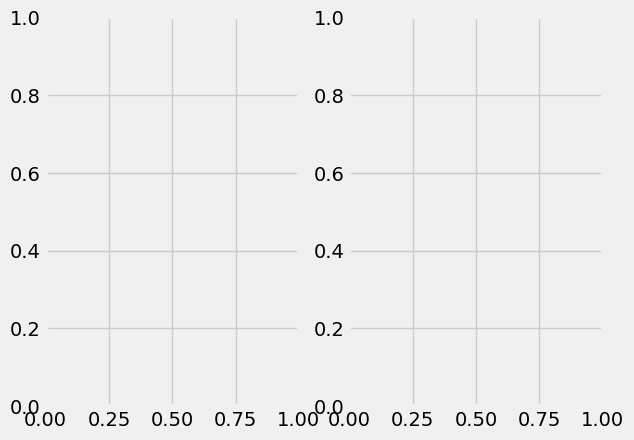

In [9]:
epochs = range(1, N_EPOCHS+1)
fig, axs = plt.subplots(1, 2)

axs[0, 0].plot(epochs, baseline_loss, label='Baseline Loss')
#axs[0, 0].plot(epochs, vi_loss, label='VI Loss')
#axs[0, 0].plot(epochs, mc_loss, label='MC Loss')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(epochs, baseline_ci, label='Baseline CI')
axs[0, 1].plot(epochs, vi_ci, label='VI CI')
axs[0, 1].plot(epochs, mc_ci, label='MC CI')
axs[0, 1].set_title('Axis [0, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

for ax in axs.flat:
    ax.label_outer()

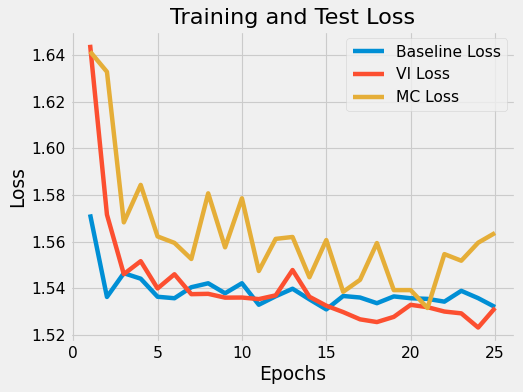

In [44]:
plt.figure(dpi=80)
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, baseline_loss, label='Baseline Loss')
plt.plot(epochs, vi_loss, label='VI Loss')
plt.plot(epochs, mc_loss, label='MC Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

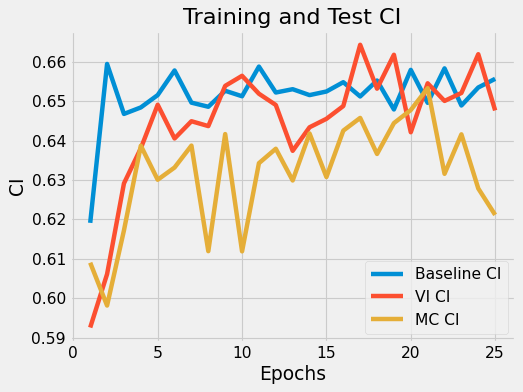

In [42]:
plt.figure(dpi=80)
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, baseline_ci, label='Baseline CI')
plt.plot(epochs, vi_ci, label='VI CI')
plt.plot(epochs, mc_ci, label='MC CI')
plt.title('Training and Test CI')
plt.xlabel('Epochs')
plt.ylabel('CI')
plt.legend()